In [5]:
%load_ext autoreload

%autoreload 2
import matplotlib.pyplot as plt
import pickle
import emcee
from astropy.coordinates import SkyCoord, match_coordinates_3d, match_coordinates_sky
import sys
import numpy as np
from astropy.table import Table, QTable, hstack, vstack, join
import iminuit
from iminuit import Minuit
import corner
import os
import clmm
from clmm import Cosmology
from astropy.table import Table, QTable, hstack, vstack
import pyccl as ccl
from astropy.cosmology import FlatLambdaCDM
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_ccl  = ccl.Cosmology(Omega_c=0.265-0.0448, Omega_b=0.0448, h=0.71, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)

#module from my personnal github
sys.path.append('/pbs/throng/lsst/users/cpayerne/CLMassDC2/modules/')
import analysis_Mass_Richness_relation as analysis
#import CL_WL_miscentering as mis
import CL_WL_DATAOPS_make_profile as prf
import CL_WL_two_halo_term as twoh
import CL_WL_mass_conversion as utils
#import CL_WL_fit_cluster_mass as fit
import CL_Likelihood_for_Mass_richness_relation as mr
import CL_fiducial_mass_richness_relation as fiducial
sys.path.append('/pbs/throng/lsst/users/cpayerne/ClusterLikelihoods/modules/')
import utils as ut

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

# Load data

In [23]:
profile_true = load('/pbs/throng/lsst/users/cpayerne/CLMassDC2/data/data_new_version/ind_profile_redmapper.pkl')
#profile_true=prf.load_profile(profile_name = '/pbs/throng/lsst/users/cpayerne/CLMassDC2/data/individual_profile_cosmoDC2_gal_redMaPPer_cluster_epsilon_shape_true_z.pkl'
#                              , r_in = 'radius_av', gt_in = 'gt_av', gx_in = 'gx_av', weight = 'norm_sum',
#                          rmin = 1, rmax = 10)
#lens_catalog=load('/pbs/throng/lsst/users/cpayerne/CLMassDC2/data/lens_catalog_redMaPPer.pkl')

In [24]:
profile_true


id,ra,dec,redshift,richness,DSt_true,DSx_true,W_l_true,radius_true,DSt_flex,DSx_flex,W_l_flex,radius_flex,DSt_bpz,DSx_bpz,W_l_bpz,radius_bpz
int64,float64,float64,float32,float32,float64[15],float64[15],float64[15],float64[15],float64[15],float64[15],float64[15],float64[15],float64[15],float64[15],float64[15],float64[15]
4835,60.1207701187705,-35.74737806182082,0.8966372,21.559492,181970202039987.4 .. -28443127135230.145,-121039939628388.1 .. -21985931615491.89,1.4180508196511585e-30 .. 2.0250401348304404e-28,0.5527313667973088 .. 9.109776808324828,186844158302200.06 .. -28130753176707.68,-94406510728502.52 .. -23161785687557.227,1.2809401389525147e-30 .. 2.00502872517232e-28,0.5526983369189398 .. 9.107341532359275,229408661422969.3 .. -30475882564310.934,-108653582159705.6 .. -23529352904882.918,1.1542652404066941e-30 .. 1.8563679470487896e-28,0.5570769071349138 .. 9.105309294464476
469,50.8966866200705,-44.45493260669247,0.62144566,67.09559,101473623143260.23 .. -10043112864669.078,-35887467578322.05 .. -1437950060441.7378,3.0116534980031034e-30 .. 8.233913568744426e-28,0.5517712415705935 .. 9.121209309502692,107897703822353.47 .. -10165490715356.232,-41169782555698.96 .. -1353983749805.2114,2.9963764470191383e-30 .. 8.248629622102231e-28,0.552239228793423 .. 9.120522698056662,100454892424314.47 .. -11818278402811.826,-35638929602281.72 .. -1889540588074.1912,2.8685370633676007e-30 .. 7.7917764479001615e-28,0.551797720465266 .. 9.125507961269342
7043,72.99011209131204,-40.587925971785054,0.889254,20.217054,97881380813686.16 .. 3887784045769.054,8072260980519.0 .. 1044440307522.794,9.633161809747258e-31 .. 1.9732417114529207e-28,0.5736735982046974 .. 9.14595416598728,93953737194012.14 .. 4145301969984.8984,7039094084410.3125 .. 1641104810481.4553,9.543965840067045e-31 .. 1.954503218913488e-28,0.5728915484293453 .. 9.144104324927497,126276479793492.92 .. 9473736202452.504,-41687767791710.445 .. 6800227385406.311,7.040289281137459e-31 .. 1.8237833212338301e-28,0.5742616367375348 .. 9.15928227130137
3356,49.211119675755015,-31.117136628863747,0.60960704,26.258024,-10376143498329.596 .. -2325086854171.113,159996224784037.97 .. -2612206554365.4937,2.8203970915992385e-30 .. 6.505801834573477e-28,0.5539945696756196 .. 9.127824858851557,-5422831698024.002 .. -1965062340104.346,157798891268474.9 .. -2005404590317.263,2.8592699160753785e-30 .. 6.551576855809062e-28,0.5536524789085484 .. 9.126757912192435,13841718145833.443 .. -2693003317705.131,174246427292332.88 .. -724987637473.043,2.768877373940194e-30 .. 6.361042717974786e-28,0.5569526443568353 .. 9.125734944364337
4405,57.00381256004044,-31.200967027470817,0.41625932,21.879847,239179990463104.6 .. -1260336771650.6157,28313931125033.656 .. 430047622508.0653,1.1700788547153446e-29 .. 2.1093841410489106e-27,0.5525299141278757 .. 9.121906300526922,240719445093826.3 .. -1249963123100.8247,27727088470384.67 .. 366839947505.8924,1.1681332259714397e-29 .. 2.1108101095421127e-27,0.5522587683943728 .. 9.121500003910127,245870593739057.78 .. -2299263070897.441,15145051713930.822 .. 245773558391.89246,1.1106164621357106e-29 .. 2.0443073241787993e-27,0.5533498436412896 .. 9.12224726579502
4343,58.4235667390495,-29.20874410125269,0.7108572,25.739355,43003326717340.85 .. 29548754728615.17,-55140034360060.26 .. 5429590487048.838,1.4902812857260423e-30 .. 5.6228558367708965e-28,0.5553711496930266 .. 9.136175884230136,43338141752699.57 .. 29288626526524.56,-56919305571446.6 .. 5437081045188.817,1.4502489951400324e-30 .. 5.611660500608422e-28,0.5547021664564906 .. 9.135731232833145,59882654625334.91 .. 26925714683992.332,30674387107227.754 .. 7114492949555.313,1.0951124555678614e-30 .. 5.383743053476121e-28,0.5508709433501978 .. 9.135874034629675
972,70.95326443716387,-29.52459979191898,0.76803654,36.98227,73040774000207.66 .. 10248684606887.037,122039648881910.39 .. 2206985935057.5806,2.0791472452451452e-30 .. 4.054505526354732e-28,0.5585977774313011 .. 9.097858562657224,87577968146683.62 .. 986060

In [25]:
Z_bin = analysis.Z_bin
Obs_bin = analysis.Obs_bin

# Fit WL mass

## Estimating shear profiles & covariances

In [30]:
profile_true['cluster_id'] = profile_true['id']
profile_stack=prf.stacked_profile(profile = profile_true,
                    r_in = 'radius_true',
                    gt_in = 'DSt_true', gx_in = 'DSx_true',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'W_l_true',
                    z_name = 'redshift', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)

140
73
14
6
252
104
13
6
300
137
17
17
354
122
19
12
367
153
31
14
304
139
21
7
650
288
32
22


In [50]:
r_corner=np.logspace(np.log10(.1), np.log10(10), 30)
shapen=prf.shape_noise_ds(profile = profile_stack,z_name = 'z_mean',
                          r_corner=r_corner, 
                          shapenoise=0.15, ns_arcmin2=26, 
                          cosmo=cosmo)

In [60]:
covariance_true_stack = prf.jacknife_covariance(profile = profile_true,
                    r_in = 'radius_true',
                    gt_in = 'DSt_true', gx_in = 'DSx_true',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'W_l_true',
                    n_jack = 100,
                                                ra = 'ra', dec = 'dec',
                                                #n_boot = 600,
                    z_name = 'redshift', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)

In [61]:
def corr(cov):
    corr = np.zeros(cov.shape)
    for i in range(cov.shape[0]):
        for j in range(cov.shape[1]):
            corr[i,j] = cov[i,j]/(np.sqrt(cov[i,i]*cov[j,j]))
    return corr

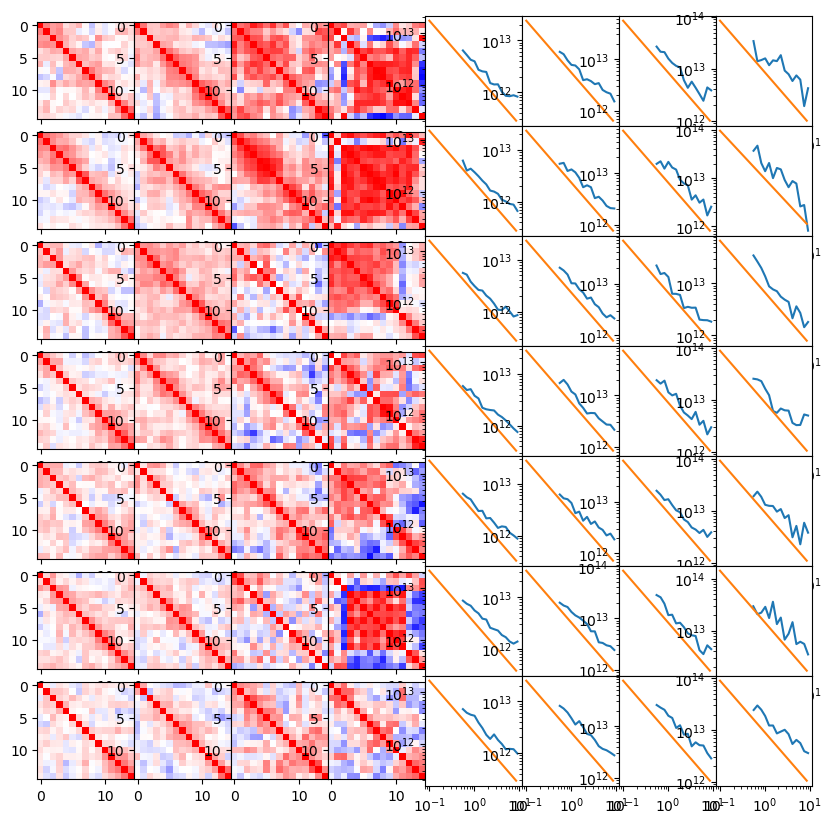

In [62]:
nz=len(Z_bin)
nobs=len(Obs_bin)
fig, ax=plt.subplots(nz, 2*nobs, figsize=(10,10),)
plt.subplots_adjust(wspace=0, hspace=0)
for i, z in enumerate(Z_bin):
    for j, obs in enumerate(Obs_bin):
        mask_z = (profile_stack['z_mean'] > z[0])*(profile_stack['z_mean'] < z[1])
        mask_m = (profile_stack['obs_mean'] > obs[0])*(profile_stack['obs_mean'] < obs[1])
        index = np.arange(len(profile_stack['z_mean']))
        index_cut = index[mask_m * mask_z][0]
        cov=covariance_true_stack['cov_t'][index_cut]
        rmin, rmax=1, 5.5
        indexs=np.arange(len(profile_stack['radius'][0]))
        index_cuts = indexs[(profile_stack['radius'][0]>rmin)*(profile_stack['radius'][0]<rmax)]
        istart, iend=index_cuts[0], index_cuts[-1]
        
        cov_plot=cov
        ax[i,j].imshow(corr(cov_plot),vmin=-1, vmax=1, cmap = 'bwr')
        #ax[i,j].imshow(np.corrcoef(cov_plot),vmin=0, vmax=1)
        #im = ax[i,j].imshow(np.log10(abs(covariance_true_stack['cov_t'][index_cut])), cmap='bwr')
        #plt.colorbar(im, ax=ax[i,j])
        ax[i,j+nobs].loglog(profile_stack[index_cut]['radius'], cov.diagonal()**.5)
        ax[i,j+nobs].loglog(r_corner[0:-1], shapen[index_cut]**.5)